In [91]:
import os
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
from configs import get_datasets
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from PIL import Image
from models import *
import torch.backends.cudnn as cudnn
from tqdm import tqdm


### config ####
num_workers = 2
batch_size = 512
img_size = 32
dataset = 'cifar10'
CACHED_MEAN_STD = {
        'cifar10': ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        'cifar100': ((0.5071, 0.4865, 0.4409), (0.2009, 0.1984, 0.2023)),
        'stl10': ((0.4409, 0.4279, 0.3868), (0.2309, 0.2262, 0.2237)),
        'imagenet': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    }

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Visualise augmented image

In [53]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()




#### Download data ####
print('==> Preparing data..')
trainset, testset, clftrainset, num_classes, stem = get_datasets(dataset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,
                                          num_workers=num_workers, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                         pin_memory=True)
clftrainloader = torch.utils.data.DataLoader(clftrainset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                             pin_memory=True)


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
##### Transformation #####
def ColourDistortion(s=1.0):
    # s is the strength of color distortion.
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort


transform_train = transforms.Compose([
        transforms.RandomResizedCrop(img_size, interpolation=Image.BICUBIC),
        transforms.RandomHorizontalFlip(),
        ColourDistortion(s=0.5),
        transforms.ToTensor(),
        transforms.Normalize(*CACHED_MEAN_STD[dataset]),
    ])


Files already downloaded and verified


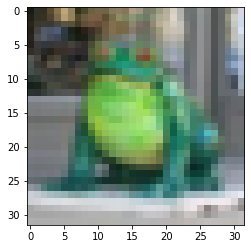

In [54]:
root = '/data/cifar10/'
train = torchvision.datasets.CIFAR10(root = root, train=True, download=True)
pic = train[19][0]
plt.imshow(pic)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


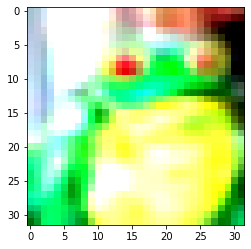

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


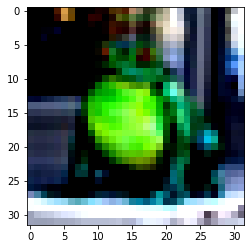

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


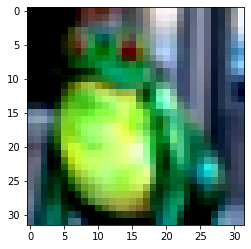

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


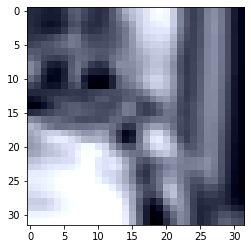

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


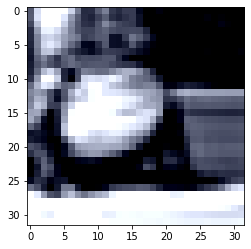

In [55]:
for i in range(5):
    tf_train = transform_train(pic)
    imshow(tf_train)

# Helper function

In [83]:
### now we put stuff together to see the distribution of p(h|x) for a pic
def get_x(sample = 100, index = 19):
    x = []
    pic = train[index][0]
    for i in range(sample):
        tf_pic = transform_train(pic)
        x.append(tf_pic)
    return x

def get_h(x, filename):
    '''
    Input: filename which is the checkpoint file
    
    Return: h|x
    '''
    ######## Load encoder from checkpoint #######
    net = ResNet18()
    net = net.to(device)

    if device == 'cuda':
        repr_dim = net.representation_dim
        net = torch.nn.DataParallel(net)
        net.representation_dim = repr_dim
        cudnn.benchmark = True

    #print('==> Loading encoder from checkpoint..')
    resume_from = os.path.join('./checkpoint', filename)
    checkpoint = torch.load(resume_from)
    net.load_state_dict(checkpoint['net'])
    
   ######## Encode ########
    h = []
    #print('==> Encoding x..')
    for i in range(len(x)):
        tf_pic = x[i]
        tf_pic = tf_pic.unsqueeze(0)
        encoded_train = net(tf_pic)
        h.append(encoded_train)
        
    return h

#### function to calculate covariance matrix and trace of cov #####
def get_cov_h(x, filename):
    h = get_h(x, filename)
    h_np = np.array([h[i].cpu().detach().numpy()[0] for i in range(len(h))])
    covMatrix = np.cov(h_np)
    
    return covMatrix

def get_trace_h(x, filename):
    h = get_h(x, filename)
    h_np = np.array([h[i].cpu().detach().numpy()[0] for i in range(len(h))])
    covMatrix = np.cov(h_np)
    trace = np.trace(covMatrix)
    
    return trace

# Now we calculate E_x( h|x)

In [105]:
randomseed = 1
np.random.seed(randomseed)
#B: number of pictures we sample from train set
B = 100
pic_index = np.random.randint(low = 0, high = len(train), size = B)
#sample augmented image !
X = [get_x(sample = 100, index = pic_index[i]) for i in range(B)]

In [106]:
trace_h = {}
checkpointfile = ['resnet18.pth99']+ ['resnet18.pth' + str(i) + '99' for i in range(1,10)]
for cp in tqdm(checkpointfile):
    mean_trace = np.mean([get_trace_h(X[i], cp) for i in range(len(X))])
    trace_h[cp] = mean_trace
    

100%|██████████| 10/10 [10:55<00:00, 65.54s/it]


In [107]:
trace_h

{'resnet18.pth99': 3.33895371052799,
 'resnet18.pth199': 2.193934828698457,
 'resnet18.pth299': 0.6288725709990552,
 'resnet18.pth399': 0.3550814715172337,
 'resnet18.pth499': 0.3049745923881842,
 'resnet18.pth599': 0.27711119263693496,
 'resnet18.pth699': 0.26078521895175416,
 'resnet18.pth799': 0.24584218262245966,
 'resnet18.pth899': 0.2621345924044697,
 'resnet18.pth999': 0.2589456816017984}

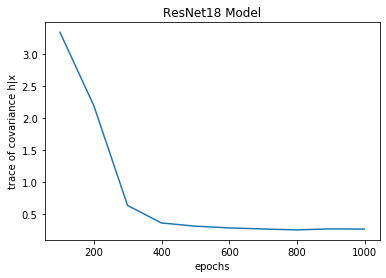

In [108]:
plt.plot([99+ 100*i for i in range(10)], [trace_h[cp] for cp in checkpointfile])
plt.xlabel('epochs')
plt.ylabel('trace of covariance h|x')
plt.title('ResNet18 Model')
plt.show()